# Grupo 20: Thiago e Gabriele

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn import preprocessing

In [2]:
df = pd.read_csv('trabalho6_dados_20.csv')

## Análise inicial

Como observado na tabela abaixo temos 3 colunas numéricas do tipo float, com as seguintes descrições

- **temperatura**: Temperatura ambiente em graus Celsius;
- **vacuo**: Pressão do vapor de escape medida em cm Hg; e
- **energia**: Quantidade de energia produzida em mega watts.

E um total de 11481 registros disponíveis.

In [3]:
df

,temperatura,vacuo,energia
0,23.82,44.89,445.45
1,22.72,69.84,436.70
2,12.11,41.17,475.53
3,30.27,64.05,438.68
4,15.23,37.87,464.02
...,...,...,...
11477,24.26,61.02,442.86
11478,21.67,69.71,440.16
11479,11.43,40.22,477.50
11480,27.60,69.05,436.08


Também pode ser observado que há 3 faixas distintas de máximos e mínimos de cada variável.

In [4]:
df.describe()

,temperatura,vacuo,energia
count,11482.000000,11482.000000,11482.000000
mean,19.740275,54.433817,454.117745
std,7.437203,12.682335,17.079184
min,1.810000,25.360000,425.120000
25%,13.670000,41.780000,439.520000
50%,20.550000,52.720000,451.015000
75%,25.760000,66.540000,467.957500
max,37.110000,81.560000,495.760000


E por fim é observado que não há dados faltantes nem dados nulos. E que todas as colunas das variáveis possuem o tipo float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11482 entries, 0 to 11481
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperatura  11482 non-null  float64
 1   vacuo        11482 non-null  float64
 2   energia      11482 non-null  float64
dtypes: float64(3)
memory usage: 269.2 KB


## Visualização

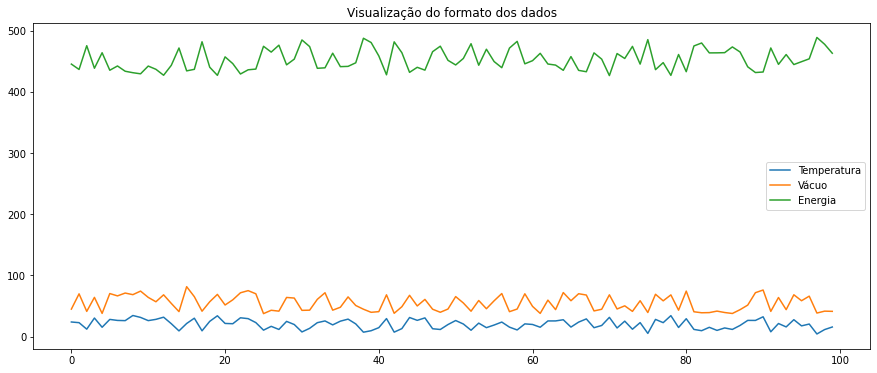

In [6]:
plt.figure(figsize=(15,6))
plt.plot(df.head(100)['temperatura'], label='Temperatura')
plt.plot(df.head(100)['vacuo'], label=u'Vácuo')
plt.plot(df.head(100)['energia'], label='Energia')
plt.title('Visualização do formato dos dados')
plt.legend()
plt.show()

No gráfico acima pode se observar que os dados das colunas Temperatura e Vácuo estão em faixas ligeiramente distintas, enquanto isso a Energia está bem acima das outras duas. Assim, como ambas estão em escalas diferentes é necessária uma normalização para maior eficiência dos algoritmos de regressão.

<AxesSubplot:>

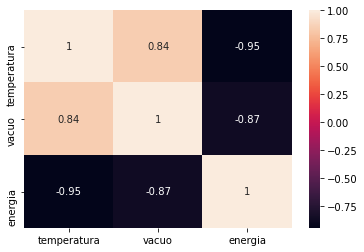

In [7]:
correlacao = df.corr()
sns.heatmap(correlacao, annot=True)

Também podemos observar pela matriz de correlação que as variáveis Temperatura e Vácuo tem forte correlação inversa (Maior que 80%) com a coluna Energia.

## Normalização

Nessa etapa os dados são normalizados num intervalo de 0 a 1

In [115]:
scaler = preprocessing.MinMaxScaler( feature_range=(0, 1) )
#x_norm = scaler.fit_transform(df)
df_norm = pd.DataFrame( scaler.fit_transform(df), columns=df.columns )
df_norm

,temperatura,vacuo,energia
0,0.623513,0.347509,0.287797
1,0.592351,0.791459,0.163930
2,0.291785,0.281317,0.713618
3,0.806232,0.688434,0.191959
4,0.380170,0.222598,0.550680
...,...,...,...
11477,0.635977,0.634520,0.251133
11478,0.562606,0.789146,0.212911
11479,0.272521,0.264413,0.741506
11480,0.730595,0.777402,0.155153


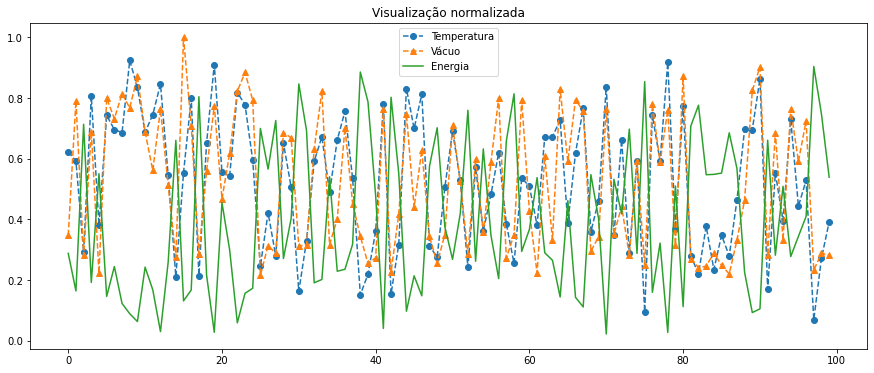

In [116]:
plt.figure(figsize=(15,6))
plt.plot(df_norm.head(100)['temperatura'], 'o--', label='Temperatura')
plt.plot(df_norm.head(100)['vacuo'], '^--',label='Vácuo')
plt.plot(df_norm.head(100)['energia'], label='Energia')
plt.title('Visualização normalizada')
plt.legend()
plt.show()

Os dados normalizados ficam dentro da mesma escala, facilitando a sua utilização pelos algoritmos de regressão abaixo.

# Análise de distribuição

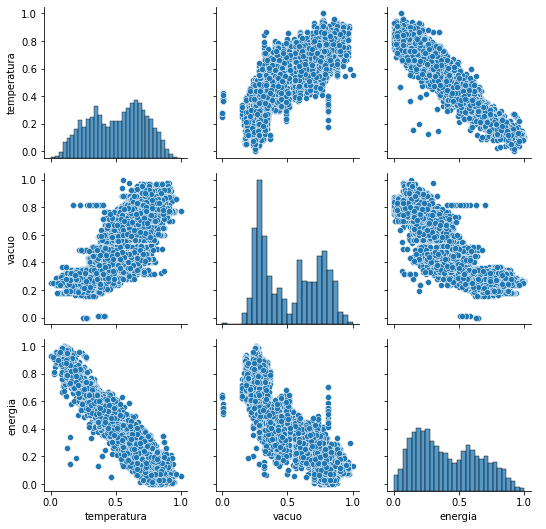

In [117]:
g = sns.PairGrid(df_norm)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

# Testando Modelos de Regressão

Questões que devem ser levadas em consideração quando escolhemos um modelo para aplicar os dados:
* Tamanho do dataset;
* Acurácia retornada pelo modelo;
* Tempo de processamento;
* Tipo de distribuição;
* Quantidade de variáveis independentes.

Além de escolher o tipo de modelo que se deseja aplicar:
* Não supervisionado;
* Supervisionado;
* Semi-supervisionado.

#### Separando em conjunto de teste e treinamento

Para este trabalho, escolhemos aplicar métodos supervisionados.

In [299]:
from sklearn.model_selection import train_test_split
X = df_norm.drop(columns='energia')
y = df_norm['energia']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.30,random_state= 20200301)

In [321]:
#montando o csv
ytest_csv = pd.DataFrame(index=ytest.index,columns=['y_original','RegMult','KNN_temperatura','KNN_vacuo','ElasticNet'])
ytest_csv['y_original'] = ytest

### Regressão Linear Múltipla

Deve se assumir para aplicar o modelo de regressão múltipla OLS:
* alta correlação entre cada duas variáveis independentes do modelo;
* O valor do erro médio dos termos independentes deve ser zero;
* A amostra obtida para o modelo de regressão OLS deve ser retirada aleatoriamente da população;
* Todos os termos de erro na regressão devem ter a mesma variância entre as variáveis independentes.


In [16]:
import statsmodels.api as sm
#A Regressão linear só funciona quando temos uma variável dependente e outra independente
#como temos mais de uma variável independente, precisamos utilizar o um modelo de regressão linear múltipla

# é necessário adicionar uma constante a matriz X
X_sm = sm.add_constant(X)
# OLS vem de Ordinary Least Squares e o método fit irá treinar o modelo
results = sm.OLS(y, X_sm,end=True).fit()
# mostrando as estatísticas do modelo
print(results.summary())
# mostrando as previsões para o mesmo conjunto passado
y_res = results.predict(X_sm)
ytest_csv['RegMult'] = y_res


                            OLS Regression Results                            
Dep. Variable:                energia   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 6.236e+04
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:01:14   Log-Likelihood:                 14211.
No. Observations:               11482   AIC:                        -2.842e+04
Df Residuals:                   11479   BIC:                        -2.839e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9783      0.002    562.546      

Interpretando o resultado:
* $\bf R-quadrado$: ou coeficiente de determinação, é uma medida estatística de quão bem a linha de regressão se ajusta aos dados;
* $\bf R-quadrado ajustado$: ajusta a estatística, levando em consideração a quantidade de variáveis independentes presentes;
* $\bf estatística-t$: é a razão de desvio do valor estimado de um parâmetro de seu valor hipotético para seu erro padrão;
* $\bf estatística-F:$ é calculada como a razão entre o erro quadrático médio do modelo e o erro quadrático médio dos resíduos.

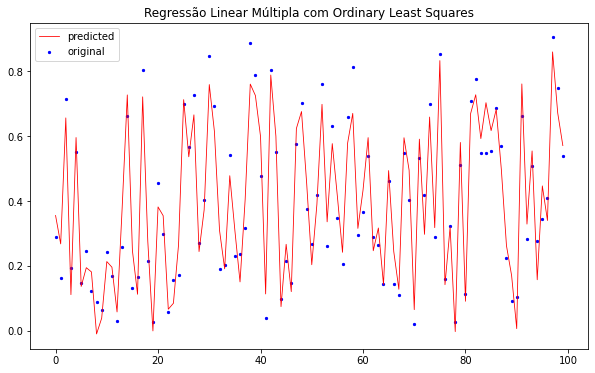

In [17]:
plt.figure(figsize=(10,6))
x_ax = range(len(X))
plt.scatter(x_ax[:100],y[:100], s=5, color="blue", label="original")
plt.plot(x_ax[:100], y_res[:100], lw=0.8, color="red", label="predicted")
plt.title('Regressão Linear Múltipla com Ordinary Least Squares')
plt.legend()
plt.show()

### KNN

O algoritmo k-nearest neighbors algorithm é usado em modo regressão e por aprendizado supervisionado.

A ideia básica do funcionamento é que, dado um conjunto de pontos $P(x_i,y_i)$ é montada uma matriz de distâncias entre todos esses pontos. Para avaliação da distância há vários algoritmos disponíveis. No código abaixo é usado algoritmo padrão "minkowski". 

Após a criação dessa matriz, um novo ponto $P'(x_i',y_i')$ é criado e avaliado usando a matriz de distâncias. Os pontos são ordenados e, no caso da configuração do código abaixo, são extraidos os 5 pontos mais próximos dele.

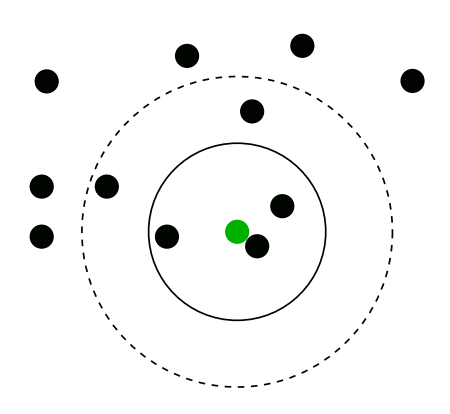

Com os pontos mais próximos do ponto $P'$ definidos, é usada a métrica de distância para calcular o valor aproximado para $y$.

temperatura - energia
R2:0.9051752084430389


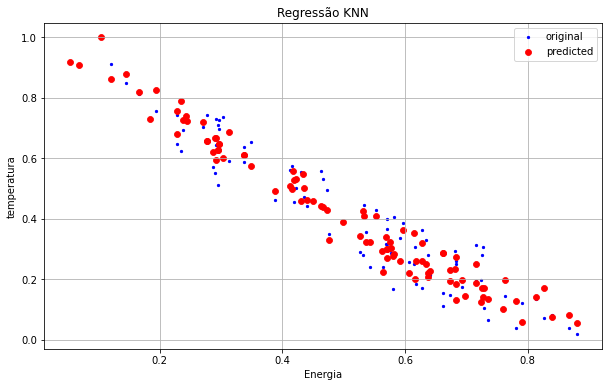

vacuo - energia
R2:0.904716647020458


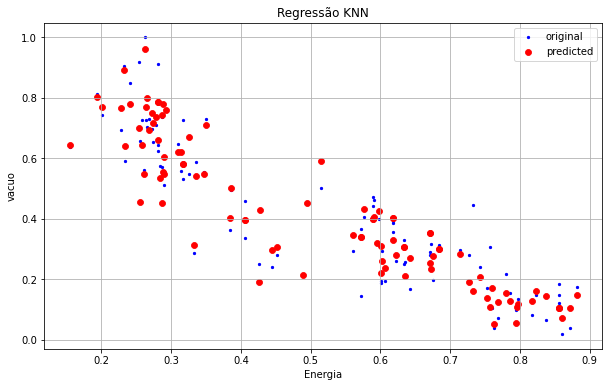

In [18]:
from sklearn.neighbors import KNeighborsRegressor

for coluna in xtrain.keys():
    print(coluna+' - energia')
    modelo = KNeighborsRegressor( n_neighbors=5, weights="distance" )

    x = xtrain[coluna].values.reshape(-1, 1)

    modelo.fit( x, ytrain.values.reshape(-1,1))

    print('R2:'+str(modelo.score(xtest[coluna].values.reshape(-1,1),ytest.values.reshape(-1,1))))

    knn_pred = modelo.predict(xtest[coluna].values.reshape(-1,1))
    
    ytest_csv['KNN_'+coluna] = knn_pred

    plt.figure(figsize=(10,6))
    plt.scatter(xtest[coluna][:100],ytest[:100], s=5, color="blue", label="original")
    plt.scatter(xtest[coluna][:100], knn_pred[:100], lw=0.8, color="red", label="predicted")
    plt.title('Regressão KNN')
    plt.xlabel('Energia')
    plt.ylabel(coluna)
    plt.grid()
    plt.legend()
    plt.show()


Como foi observado nos gráficos, foi obtido um desempenho semelhante entre as duas colunas e a energia. Sendo que ambas obtiveram um índice R2 com valor superior a 0.9, e como nesse indice quanto mais próximo de 1, melhor, indica que a previsão tem uma qualidade razoável.

### ElasticNet

R2:0.9104754933372313


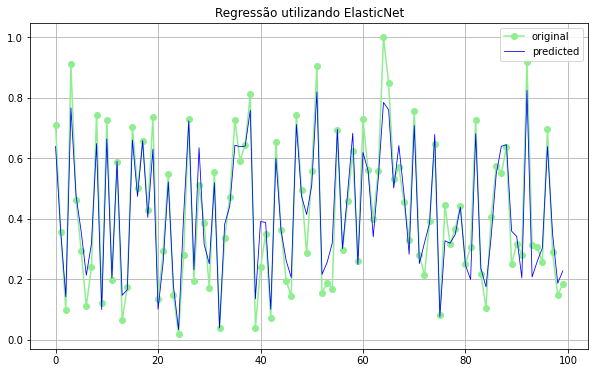

In [19]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_predict

elastic=ElasticNet(alpha= 0.004).fit(xtrain, ytrain)
print('R2:'+str(elastic.score(xtest,ytest)))

y_elastic = cross_val_predict(elastic,xtest,ytest,cv=5)

ytest_csv['ElasticNet'] = y_elastic

plt.figure(figsize=(10,6))
plt.plot(x_ax[:100],ytest[:100], '-o',color="lightgreen", label="original")
plt.plot(x_ax[:100], y_elastic[:100], lw=0.8, color="blue", label="predicted")
plt.title('Regressão utilizando ElasticNet')
plt.grid()
plt.legend()
plt.show()

In [21]:
# ytest_csv.to_csv('trabalho6_teste.csv')